In [1]:
from pprint import pprint
import os

import pandas as pd
import tsfel
from tsfel.feature_extraction.calc_features import calc_features

from script.dataset import data_dir, dataset_path, emg_cols, emg_cols_cal, get_feature_list
from script.visualization import pretty_str

In [2]:
# anonymize people's names to integers
_person2int = dict[str, int]()
def _anonymize(person: str) -> int:
    if person in _person2int:
        return _person2int[person]
    else:
        new_id = len(_person2int)
        _person2int[person] = new_id
        return new_id

In [3]:
# read frame boundaries file from csv or xlsx
def _get_frame_boundaries(recording_path: str) -> pd.DataFrame:
    for extension, reader in [('csv', pd.read_csv), ('xlsx', pd.read_excel)]:
        bounds_path = os.path.join(recording_path, f'frame_boundaries.{extension}')
        if os.path.exists(bounds_path):
            return reader(bounds_path)
    raise Exception(f'Frame boundary definitions for {recording_path} missing')

In [4]:
def _get_features(bounds, data) -> tuple[str, pd.Series]:
    condition = (data['frame'] >= bounds['frame_start']) & (data['frame'] <= bounds['frame_end'])
    df = data.loc[condition, emg_cols]
    features = calc_features(df, get_feature_list(), 50)
    return (bounds['label'], features)

In [8]:
def main():
    dataset = None
    
    for day_name in os.listdir(data_dir):
        day_path = os.path.join(data_dir, day_name)
        if not os.path.isdir(day_path): continue
    
        # get day & recording index
        recording_components = day_name.split('-')
        day = recording_components[0]
        recording = int(recording_components[1]) if len(recording_components) > 1 else '1'
    
        for person in os.listdir(day_path):
            recording_path = os.path.join(day_path, person)
            if not os.path.isdir(recording_path): continue
    
            person_id = f'Person #{_anonymize(person)}'
    
            try:
                bounds = _get_frame_boundaries(recording_path)
            except Exception as e:
                print(f'Error: {", ".join(e.args)}, skipping')
                continue
    
            data_path = os.path.join(recording_path, 'data.csv')
            with open(data_path, 'r') as fp:
                data = pd.read_csv(fp)

            set_index = 1
            for _, row in bounds.iterrows():
                if row['label'] == 'calibration': continue
    
                hold, features = _get_features(row, data)
                if dataset is None:
                    dataset = pd.DataFrame({
                        'person': [person_id],
                        'date': [day],
                        'recording': [recording],
                        'set': [set_index],
                        'hold': [pretty_str(hold)]
                    })
                    raw_values = pd.DataFrame(columns=emg_cols)
                    dataset = pd.concat([dataset, features], axis=1)
                else:
                    dataset.loc[len(dataset)] = [
                        person_id,
                        day,
                        recording,
                        set_index,
                        pretty_str(hold),
                        *features.loc[0]
                    ]
                set_index += 1
    return dataset

In [9]:
df = main()

In [10]:
label_cols = ['person', 'date', 'recording', 'set', 'hold']
feature_cols = [col for col in df.columns if col not in label_cols]

X = df[feature_cols]
y = df[label_cols]

# 

accuracy: 0.7109375


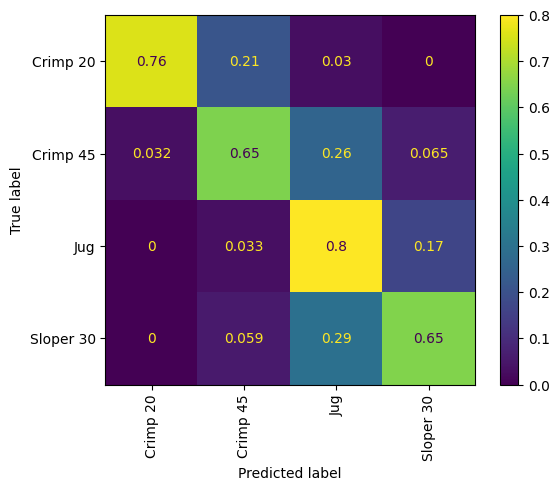

In [11]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance
from sklearn.svm import SVC
from script.visualization import report_cm

X_train, X_test, y_train, y_test = train_test_split(X, y['hold'], test_size=0.4)

svc =  SVC(kernel='rbf', C=2)
svc.fit(X_train, y_train)

y_pred = pd.Series(svc.predict(X_test))
y_pred.index = y_test.index
report_cm('', y_test, y_pred, svc)

Text(0.5, 0, 'Permutation Importance')

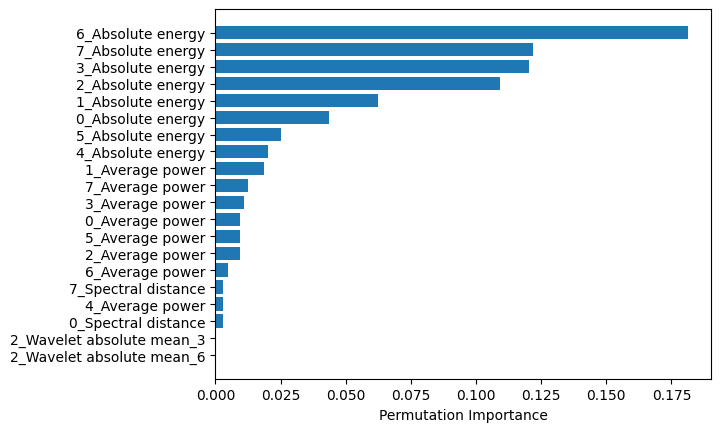

In [12]:
perm_importance = permutation_importance(svc, X_test, y_test)
features = np.array(feature_cols)
sorted_idx = perm_importance.importances_mean.argsort()
plt.barh(features[sorted_idx][-20:], perm_importance.importances_mean[sorted_idx][-20:])
plt.xlabel("Permutation Importance")